In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Forward

In [63]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.9s remaining:    4.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.2s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


# Simulate

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 19.64it/s]

Using control points [0.00000000e+00 0.00000000e+00 8.08908838e-08]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


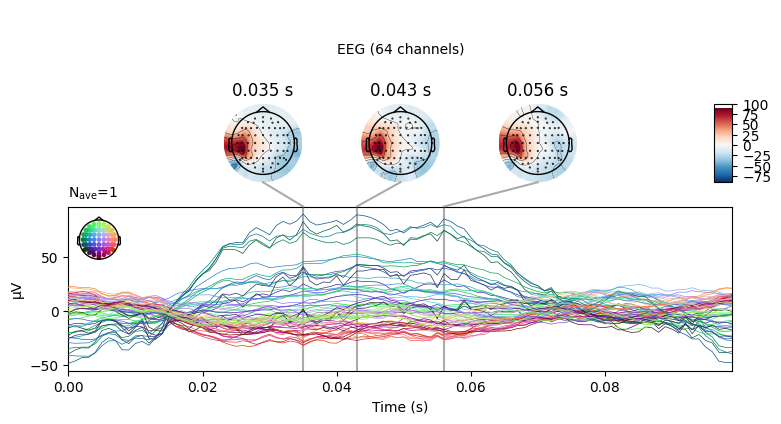

In [273]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(number_of_sources=4, extents=(1, 26), duration_of_trial=0.1, target_snr=2)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Algo

In [274]:
from invert.util import find_corner
from invert.solvers import SolverSMP
calc_smp_solution = SolverSMP().make_inverse_operator(fwd).calc_smp_solution
y -= y.mean(axis=0)
u, s, v = np.linalg.svd(y)


x_hats = []
n_chans, n_time = y.shape
idx = find_corner(np.arange(len(s)), s) + 0
# thr = 1  # 1=kaiser-guttmann np.e**(-16)
# idx = np.where((s*len(s) / s.sum()) > thr)[0][-1] + 1

topos = u[:, :idx]
print("Components: ", idx)
for topo in topos.T:
    plt.figure()
    mne.viz.plot_topomap(topo, info)
    x_hats.append( calc_smp_solution(topo) )
omegas = np.unique(np.where((np.stack(x_hats, axis=0)**2).sum(axis=0) != 0)[0])
x_hat = np.zeros((n_dipoles, n_time))
## Use different y without unnecessary components here:
x_hat[omegas, :] = np.linalg.pinv(leadfield[:, omegas]) @ y


plt.figure()
a = np.arange(len(s))
plt.plot(a, s, '*k')
plt.plot(a[idx], s[idx], 'or')
plt.xlabel("Eigenvalue No.")
plt.xlabel("Eigenvalue")




Components:  3


Text(0.5, 0, 'Eigenvalue')

In [275]:
from invert.util import calc_residual_variance
stc_ = stc.copy()
stc_.data = deepcopy(x_hat)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'SVD-SMP', 'title',
               font_size=14)
y_hat = leadfield @ x_hat
evoked_ = mne.EvokedArray(y_hat, info)
evoked_.plot_joint()
res = calc_residual_variance(y_hat, y)
print(f"residual variance: {res:.1f} %")

Using control points [0.         0.         0.54538234]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.
residual variance: 2.6 %


Using control points [0.00000000e+00 0.00000000e+00 4.18530762e-08]
Using control points [0.         0.         0.53751586]
Using control points [0.0000000e+00 0.0000000e+00 6.6089222e-08]
Using control points [0.        0.        0.4138724]
